In [107]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten,Dropout
from keras.layers import Dense
from keras.layers import LSTM , Flatten , CuDNNLSTM , GRU
from keras.layers import Dropout
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM

import keras

from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [108]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten , CuDNNLSTM , GRU
from keras.layers import Dropout
import keras

from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [109]:
def load_file(filepath,i):
    with open(filepath) as f:
        data = json.load(f)
    imu = data['imu']['data']
    emg = data['emg']['data']
    emg = np.array(emg)
    imu = np.array(imu)
    imu_gyr = np.array([(e['gyroscope']) for e in imu])
    imu_acc = np.array([(e['acceleration']) for e in imu])
    imu_orn = np.array([(e['orientation']) for e in imu])
    #timestamp = [i]
    #timestamp = np.repeat(timestamp, 400, axis=None)
    #timestamp= timestamp.reshape(400,1)
    dataset = tf.concat([emg, imu_gyr, imu_acc, imu_orn], axis=1, name='concat')
    dataset = np.array(dataset)
    return dataset

In [110]:
data_path = '../input/emgimu/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet-master/Dataset/'

In [111]:
# For Files Data
X = []
y = []
i=0
for folder in  os.listdir(data_path) : 
    j=0
    files = gb.glob(pathname= str( data_path  + folder + '/*.json'))
    for file in files: 
        data = load_file(file,j)
        X.append(data)
        y.append(i)
        j+=1
    i+=1

print(f'we have {len(X)} items in X ')

we have 780 items in X 


In [112]:
X = np.array(X)
y = np.array(y)

In [113]:
print('X shape is : ' , X.shape)
print('y shape is : ' , y.shape)

X shape is :  (780, 400, 18)
y shape is :  (780,)


In [114]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

In [115]:
def getcode(n) : 
    for x , y in mapping.items() : 
        if n == y : 
            return x

In [116]:
# For Smaples Data
new_X = []
new_y = []
for j in range(780):
    for i in range(400):
        new_X.append(X[j][i])
        new_y.append(y[j])
        


In [117]:
len(new_X)

312000

In [118]:
len(new_y)

312000

In [119]:
new_X = np.array(new_X)
new_y = np.array(new_y)


In [120]:
from sklearn.utils import shuffle
new_X, new_y = shuffle(new_X, new_y, random_state=20)

In [121]:
print('new_X shape is : ' , new_X.shape)
print('new_y shape is : ' , new_y.shape)


new_X shape is :  (312000, 18)
new_y shape is :  (312000,)


# **Bulding Model with samples data**

In [122]:
X_train, X_split, y_train, y_splitt = train_test_split(new_X, new_y, test_size=0.30, random_state=42)

In [123]:
X_test, X_valid, y_test, y_valid = train_test_split(X_split, y_splitt, test_size=0.50, random_state=42)

In [124]:
X_train.shape

(218400, 18)

In [125]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_valid = X_valid.reshape(len(X_valid), X_valid.shape[1],1)



In [126]:
y_train = to_categorical(y_train)
y_test=to_categorical(y_test)
y_valid=to_categorical(y_valid)

In [127]:

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
acc_per_fold = []
loss_per_fold = []

In [128]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten
from keras.layers import Dropout
import keras
import tensorflow as tf
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    model = Sequential()
    
    model.add(Bidirectional(CuDNNLSTM(units=265, return_sequences=True), input_shape=(18, 1)))
    model.add(Bidirectional(CuDNNLSTM(units=128, return_sequences=True)))
    model.add(Dropout(rate=0.3))
    
    model.add(Flatten())
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(64,activation='tanh'))
    
    model.add(Dense(26,activation='softmax'))
    
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
    csv_logger = CSVLogger('training_set_iranalysis3.csv',separator=',', append=False)
    

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(inputs[train], targets[train], batch_size=128, epochs=50, validation_data=(X_valid, y_valid),callbacks=[es,checkpointer,csv_logger])
    
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

    


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
1658/1658 [==============================] - 27s 15ms/step - loss: 2.5290 - accuracy: 0.2313 - val_loss: 2.2978 - val_accuracy: 0.2900
Epoch 2/50
1658/1658 [==============================] - 25s 15ms/step - loss: 2.2991 - accuracy: 0.2900 - val_loss: 2.2193 - val_accuracy: 0.3146
Epoch 3/50
1658/1658 [==============================] - 25s 15ms/step - loss: 2.2389 - accuracy: 0.3085 - val_loss: 2.1798 - val_accuracy: 0.3252
Epoch 4/50
1658/1658 [==============================] - 25s 15ms/step - loss: 2.2001 - accuracy: 0.3201 - val_loss: 2.1493 - val_accuracy: 0.3366
Epoch 5/50
1658/1658 [==============================] - 24s 15ms/step - loss: 2.1692 - accuracy: 0.3294 - val_loss: 2.1494 - val_accuracy: 0.3337
Epoch 6/50
1658/1658 [==============================] - 25s 15ms/step - loss: 2.1417 - accuracy: 0.3367 - val_loss: 2.1408 - val_accuracy: 0.3408
Epoch 7/50
1658/1658 [=====

In [129]:
model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_44 (Bidirectio (None, 18, 530)           568160    
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 18, 256)           675840    
_________________________________________________________________
dropout_43 (Dropout)         (None, 18, 256)           0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               589952    
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)              

In [130]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

model.save("./lstm.hdf5")

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.165071964263916 - Accuracy: 34.10822153091431%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.1883492469787598 - Accuracy: 33.40874910354614%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.1743388175964355 - Accuracy: 33.8103324174881%
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1764638423919678 - Accuracy: 33.996984362602234%
------------------------------------------------------------------------
> Fold 5 - Loss: 2.1779227256774902 - Accuracy: 34.0309202671051%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 33.87104153633118 (+- 0.251028701305044)
> Loss: 2.1764293193817137
-------------------------------

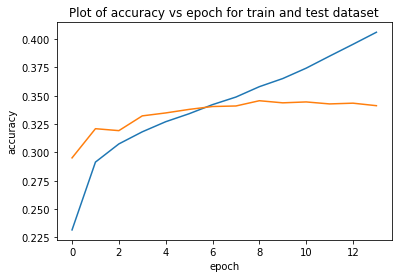

In [132]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

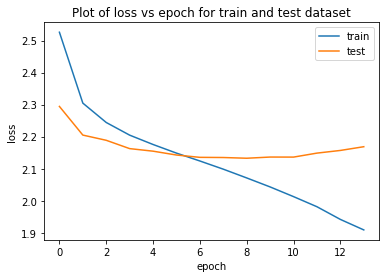

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()